1. **Import data**




First, let's import the necessary datasets and libraries.

In [1]:
#Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

We import **daily_subs** and change the format of *date* column from string to date format then inspect the data.

In [2]:
# Import daily_subs
daily_subs = pd.read_csv('https://raw.githubusercontent.com/kietha2304/NCKH/main/daily_subs.csv')
daily_subs['date'] = pd.to_datetime(daily_subs['date'], dayfirst=False) #convert string to date
daily_subs.sort_values('date')
daily_subs.set_index('date', inplace=True)

# Quick observation of the "daily_subs" dataset
daily_subs.head()
daily_subs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 685 entries, 2021-04-01 to 2023-02-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   subs    655 non-null    float64
dtypes: float64(1)
memory usage: 10.7 KB


We modified the **timeline_content** by adding related exogenous variables under dummies, which we will use for forecasting later, then we convert the *date* column from string to date format. Let's inspect the data.

In [3]:
# Import timeline_content
timeline_content = pd.read_csv('https://github.com/kietha2304/NCKH/raw/main/event_timeline.csv')
timeline_content['date'] = pd.to_datetime(timeline_content['date'], dayfirst=False)
timeline_content.set_index('date', inplace=True)
timeline_content

,Làn sóng dịch thứ 4,Rap Viet,Nguoi Ay La Ai,2 Ngay 1 Dem,The Masked Singer
date,,,,,
2021-04-01,0,0,0,0,0
2021-04-02,0,0,0,0,0
2021-04-03,0,0,0,0,0
2021-04-04,0,0,0,0,0
2021-04-05,0,0,0,0,0
...,...,...,...,...,...
2023-06-26,0,1,1,0,0
2023-06-27,0,1,1,0,0
2023-06-28,0,1,1,0,0


2. **Data Preparation**

 **2.1. Fill Missing Values**

We scrutinized the data set and we realized that the timeline of the **daily_subs** dataset has some missing dates, and we have successfully added those missing dates into the dataset.

In [4]:
daily_subs[daily_subs['subs'].isna()]

,subs
date,
2021-05-13,NaN
2021-06-14,NaN
2021-06-24,NaN
2021-07-06,NaN
2021-08-14,NaN
2021-10-06,NaN
2021-10-12,NaN
2021-11-03,NaN
2021-11-20,NaN


As can be observed, all the missing dates has been displayed. However, we do not have the data of the number of subscriptions of those missing dates. Therefore, we will use the **interpolation model** to estimate those values.

An ***interpolation model*** is a mathematical or statistical technique used to estimate values between known data points. It is used when there are missing or incomplete data points, and the goal is to fill in those gaps or estimate values at specific locations within the data range.

We will use the interpolate **linear** method to estimates the missing values based on the linear trend between the neighboring values. Linear interpolation is achieved by geometrically rendering a straight line between two adjacent points on a graph or plane. All points on the line other than the original two can be considered interpolated values.


In [5]:
# Interpolate using linear
daily_subs['subs'].interpolate(method = 'linear', inplace = True)

# Observe the result
observed_data = daily_subs['2021-05-10':'2021-05-16'].sort_index()
print(observed_data)

              subs
date              
2021-05-10  3014.0
2021-05-11  3149.0
2021-05-12  3365.0
2021-05-13  3610.5
2021-05-14  3557.0
2021-05-15  3664.0
2021-05-16  3571.0


As can be observed, the missing date 2021-05-13 has been filled with an appropriate value in subs field. We can check whether they have linearity or not.

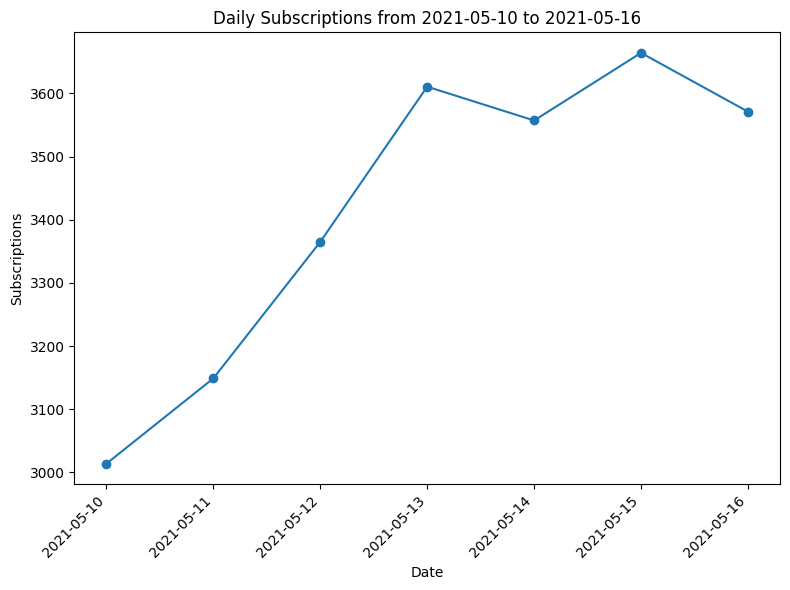

In [6]:
observed_data = daily_subs.loc['2021-05-10':'2021-05-16']

# Create a line plot
plt.figure(figsize=(8, 6))
observed_data['subs'].plot(marker='o')
plt.xlabel('Date')
plt.ylabel('Subscriptions')
plt.title('Daily Subscriptions from 2021-05-10 to 2021-05-16')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It can be clearly seen that the values have linear relationship.

**2.2. Split data in to Train and Test set**

Splitting the data into train and test sets is a common practice in **machine learning** and **time series analysis**. The purpose of splitting the data is to **evaluate the performance of a model on unseen data**.

We need to split the data into train and test sets because of those reasons:

**Model Training**: The train set is used to train the model. During training, the model learns the patterns and relationships present in the data. It adjusts its internal parameters to minimize the error between the predicted values and the actual values in the train set.

**Model Evaluation**: The test set is used to evaluate the performance of the trained model. By making predictions on the test set, we can assess how well the model generalizes to new, unseen data. This evaluation helps us understand the model's ability to make accurate predictions on data it has not been trained on.

**Preventing Overfitting**: Splitting the data helps us identify and prevent overfitting. Overfitting occurs when a model becomes too specialized in capturing the patterns and noise present in the training data, leading to poor generalization on new data. By evaluating the model on the test set, we can assess if the model has overfit the training data and adjust the model or hyperparameters accordingly.

**Performance Metrics**: The test set provides a basis for calculating performance metrics such as **mean squared error (MSE)**, **mean absolute error (MAE)**, and others. These metrics quantify the accuracy and predictive power of the model on the unseen data.

By splitting the data into train and test sets, we can estimate how well the model will perform in real-world scenarios. It helps us make informed decisions about the model's performance and provides a way to compare different models or parameter settings.

First, we selects the rows from *daily_subs* up to and including the date '2023-01-01', creating the **train data**. We selects the rows from *daily_subs* starting from the date '2023-01-01' until the end of the dataset, creating the **test data**.

After that, we selects the rows from *timeline_content* up to and including the date '2023-01-01', creating the **train event data**. We selects the rows from *timeline_content* starting from the date '2023-01-01' until '2023-2-14', creating the **test event data**.

Finally, we selects the rows from *timeline_content* starting from the date '2023-2-15' until the end of the dataset, creating the **forecast event data**.


We use the 80-20 rule (the Pareto principle) to decide the train set and test set because it provides a simple and balanced approach. It allows for a sufficient amount of data for training while reserving a separate portion for testing and evaluating the model's performance on unseen data. It helps **assess the model's ability to generalize**, **manages the bias-variance trade-off**, **serves as a benchmark for performance comparison**, and **efficiently utilizes available data**.

In [7]:
# Split daily subs into train and test data
train_data = daily_subs.asfreq('D').loc[:'2023-01-01', :]
test_data = daily_subs.asfreq('D').loc['2023-01-01':, :]
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

# Split event timeline into train test, and forecast data
train_event = timeline_content.asfreq('D').loc[:'2023-01-01', :]
test_event = timeline_content.asfreq('D').loc['2023-01-01':'2023-2-14', :]
forecast_event = timeline_content.asfreq('D').loc['2023-2-15':, :]
print(f'Train event shape: {train_event.shape}')
print(f'Test event shape: {test_event.shape}')
print(f'Forecast event shape: {forecast_event.shape}')

Train data shape: (641, 1)
Test data shape: (45, 1)
Train event shape: (641, 5)
Test event shape: (45, 5)
Forecast event shape: (136, 5)


The data has been split into the following sets:

Train data: This set contains 641 data points and consists of historical daily subscription values. It is used to train the forecasting model.

Test data: This set contains 45 data points and represents a portion of the recent subscription data. It is used to evaluate the performance of the trained model on unseen data.

Train event: This set contains 641 data points and consists of historical event information associated with each day. It is used as exogenous variables for training the model.

Test event: This set contains 45 data points and represents event information corresponding to the test data. It is used as exogenous variables for evaluating the model's performance on the test data.

Forecast event: This set contains 136 data points and represents future event information. It is used for forecasting future subscription values beyond the test period.

To better understand the structure and patterns present in the time series data, we will decomposite the datas.

3. **Decomposition**

The Decomposition Plot graphs the **observed values**, the **underlying trend**, **seasonality**, and **randomness** of the data. The method the decompose function that produces the plot uses for extracting components is Seasonal and Trend decomposition. This method is can handle any tape of seasonality and is robust to outliers.

<Figure size 1000x800 with 0 Axes>

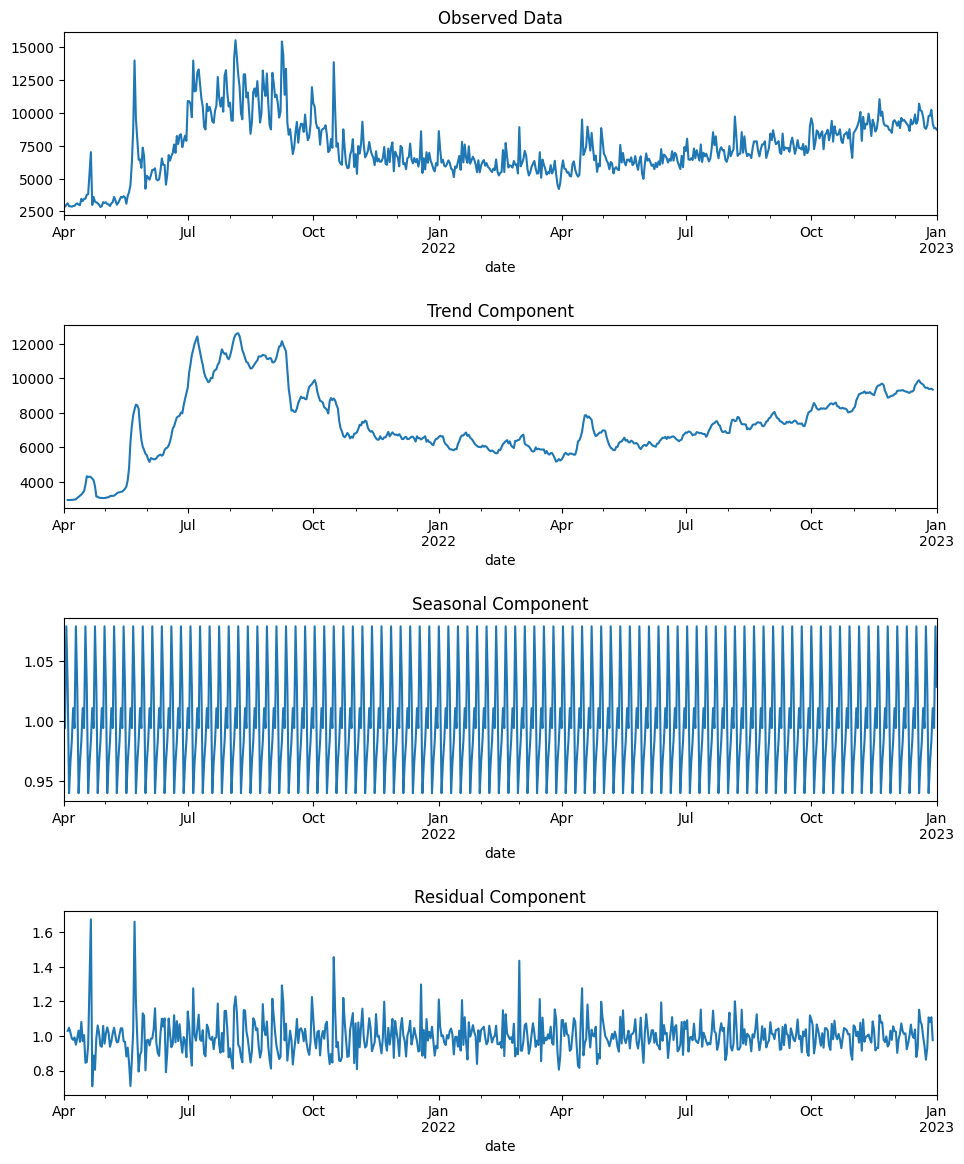

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(10, 8))
data = train_data.asfreq('D')
decompose_data = seasonal_decompose(data, model="multiplicative")
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

# Plot the seasonal, trend, and residual components
decompose_data.observed.plot(ax=axes[0])
decompose_data.trend.plot(ax=axes[1])
decompose_data.seasonal.plot(ax=axes[2])
decompose_data.resid.plot(ax=axes[3])

# Set titles for each subplot
axes[0].set_title('Observed Data')
axes[1].set_title('Trend Component')
axes[2].set_title('Seasonal Component')
axes[3].set_title('Residual Component')

# Adjust the layout and spacing between subplots
plt.tight_layout(pad=2.0)

# Show the plot
plt.show()

Here is the result.

The **Observed Data** plot shows a time series plot of the original data.

The **Trend** plot shows an upward trend at the end of each year.

The **Seasonal** plot shows the seasonal fluctuations of the data.

The **Residual** plot shows fairly random residuals.


Next, we will check for stationary as it is crucial for applying appropriate analysis techniques, **improving forecasting accuracy**, ensuring reliable statistical inference, and identifying meaningful patterns and dependencies within the data.

4. **Stationary check**

 We will check if the series is stationary using the **Augmented Dickey Fuller test (ADF Test)**, from the statsmodels package. The reason being is that we need differencing only if the series is non-stationary. Else, no differencing is needed.

In [9]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(train_data)

# Extract the p-value from the result
p_value = result[1]

# Define a significance level (e.g., 0.05)
significance_level = 0.05

print('p_value:', p_value)

# Compare the p-value with the significance level to determine stationarity
if p_value < significance_level:
    print("The data is stationary.No order differencing needed")
else:
    print("The data is not stationary. Initiate differencing")

p_value: 0.13133392683085376
The data is not stationary. Initiate differencing


The ADF test result shows that the dataset is **non-stationary**. Therefore, we need differencing to remove the trend or other non-stationary components from the series as differencing can help achieve stationarity by **stabilizing the mean**, **variance**, or **autocorrelation** to make reliable forecast.

5. **SARIMAX forecasting model**

5.1. **Find the order of differencing (d) in the model**

As the dataset is **non-stationary**, the purpose of differencing is to make the time series stationary. But we should be careful to not over-difference the series. An over differenced series may still be stationary, which in turn will affect the model parameters.

So we should determine the right order of differencing. The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

If we can’t really decide between two orders of differencing, then we go with the order that gives the least standard deviation in the differenced series.

Let’s difference the series and see how the autocorrelation plot looks like.

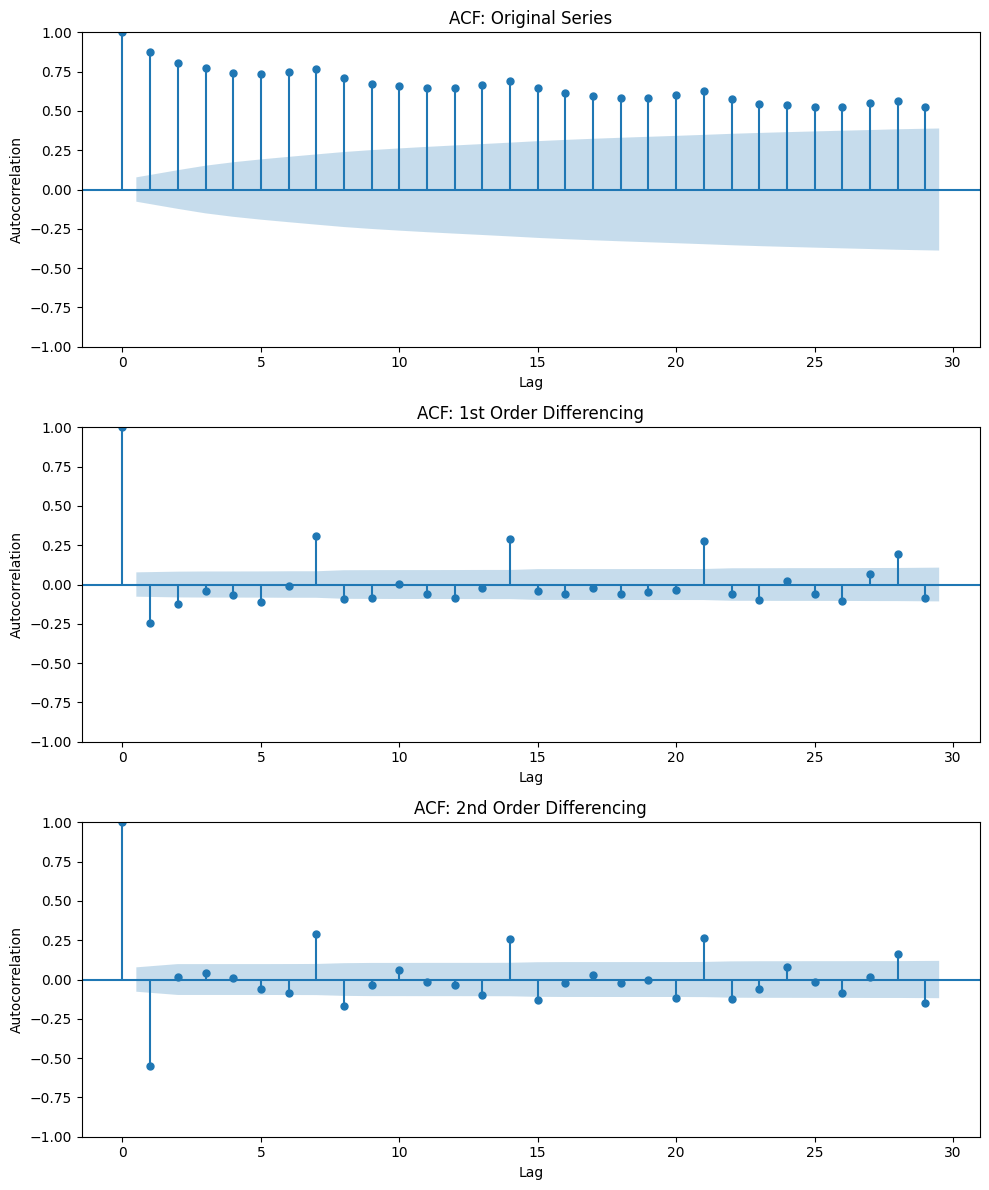

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 12))
plot_acf(train_data, ax=ax1)
plot_acf(train_data.diff().dropna(), ax=ax2)
plot_acf(train_data.diff().diff().dropna(), ax=ax3)

# Set plot titles
ax1.set_title('ACF: Original Series')
ax2.set_title('ACF: 1st Order Differencing')
ax3.set_title('ACF: 2nd Order Differencing')

# Set plot labels
ax1.set_ylabel('Autocorrelation')
ax2.set_ylabel('Autocorrelation')
ax3.set_ylabel('Autocorrelation')

# Set plot x-axis labels
ax1.set_xlabel('Lag')
ax2.set_xlabel('Lag')
ax3.set_xlabel('Lag')

plt.tight_layout()
plt.show()

For the above data, we can see that the time series reaches stationarity with one order of differencing. Here we can see that in second-order differencing the immediate lag has gone on the negative side, representing that in the second-order the series has become over the difference.

5.2. **Find the order of the AR term (p)**

In the above section, we have identified the optimal value of d. Now in this section, we are going to find the optimal value of p which is our number of autoregressive terms. We can find this value by inspecting the PACF plot.

The partial autocorrelation function plot can be used to draw a correlation between the time series and its lag while the contribution from intermediate lags can be ignored. This plotting will let us know about the lags that are not required in the autoregression part.

Significant correlation in a stationary time series can be represented by adding auto regression terms. Using the PACF plot we can take the order of AR terms to be equal to the lags that can cross a significance limit.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


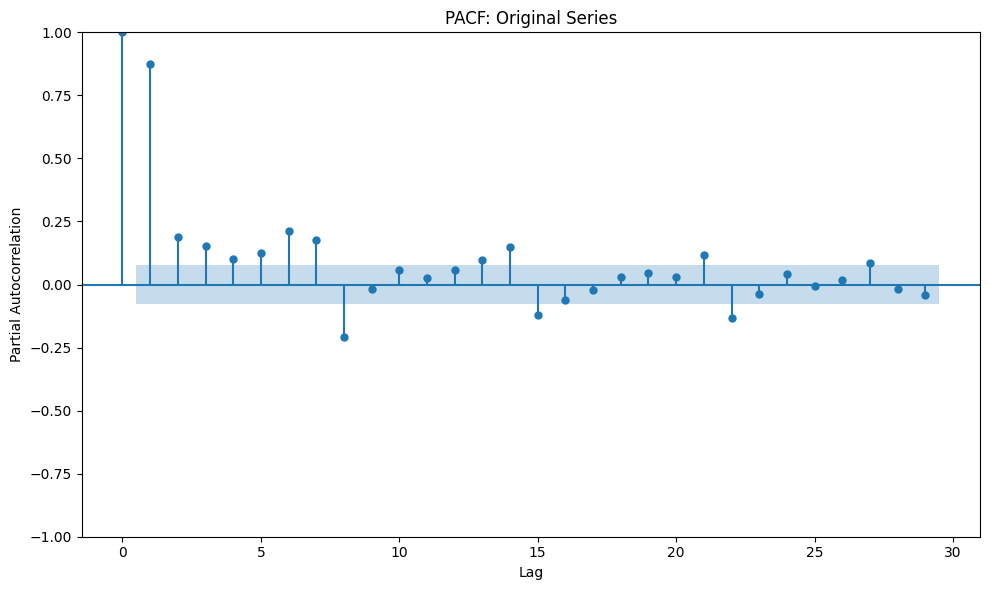

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


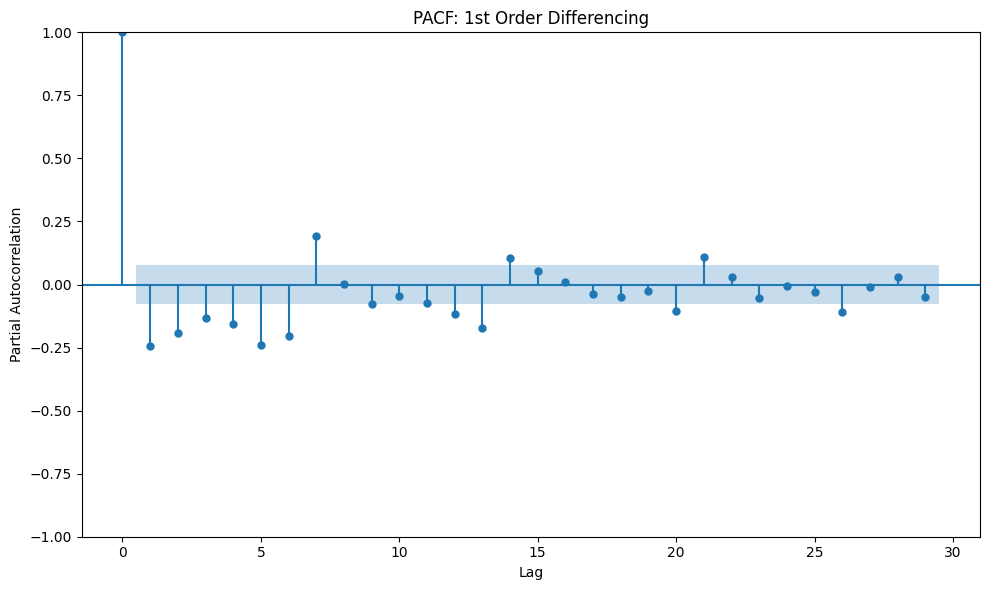

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf


# Original series PACF
plt.figure(figsize=(10, 6))
plot_pacf(train_data, ax=plt.gca())

# Set plot title
plt.title('PACF: Original Series')

# Set plot labels
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

# 1st order differencing PACF
plt.figure(figsize=(10, 6))
plot_pacf(train_data.diff().dropna(), ax=plt.gca())

# Set plot title
plt.title('PACF: 1st Order Differencing')

# Set plot labels
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

Here we can see that the first lag is significantly out of the limit and the second one is also out of the significant limit but it is not that far so we can select the order of the p as 1.

5.3. **Find the order of the MA term (q)**

To find out the value of q we can use the ACF plot. Which will tell us how much moving average is required to remove the autocorrelation from the stationary time series.

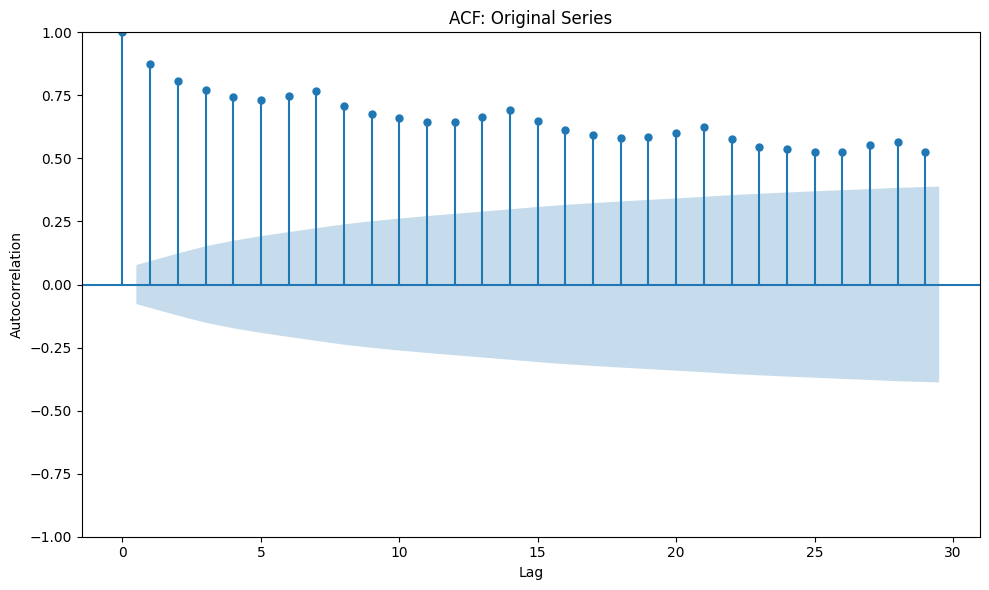

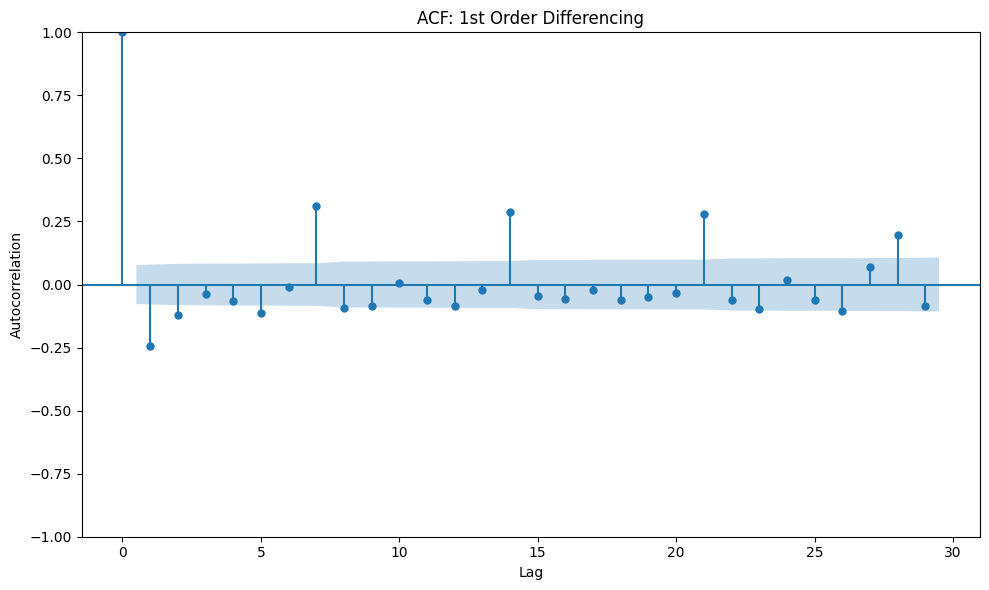

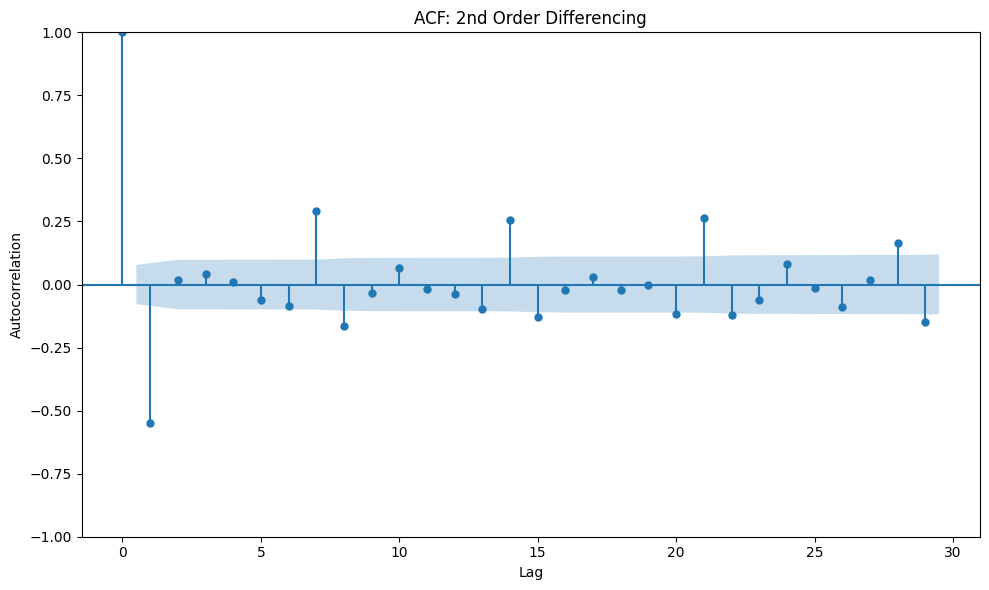

In [12]:
# 1st order differencing
diff1 = train_data.diff().dropna()

# 2nd order differencing
diff2 = diff1.diff().dropna()

# ACF of original series
plt.figure(figsize=(10, 6))
plot_acf(train_data, ax=plt.gca())

# Set plot title
plt.title('ACF: Original Series')

# Set plot labels
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

# ACF of 1st order differencing
plt.figure(figsize=(10, 6))
plot_acf(diff1, ax=plt.gca())

# Set plot title
plt.title('ACF: 1st Order Differencing')

# Set plot labels
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

# ACF of 2nd order differencing
plt.figure(figsize=(10, 6))
plot_acf(diff2, ax=plt.gca())

# Set plot title
plt.title('ACF: 2nd Order Differencing')

# Set plot labels
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

Here we can see that 2 of the lags are out of the significance limit so we can say that the optimal value of our q (MA) is 2.

5.4. **Build and validate models**

Now, we have determined the values of p, d and q. We have everything needed to fit the model. As for seasonal components, we have test many cases and found the optimist seasonal components (1,0,1,7).

These four numbers represent the seasonal components of the model: P, D, Q, and s.

P: The seasonal autoregressive (SAR) order. It represents the number of seasonal lagged observations of the dependent variable included in the model. In this case, P = 1 indicates that the model includes the lagged value of the dependent variable at the seasonal frequency.

D: The seasonal differencing order. It represents the number of times the series needs to be seasonally differenced to achieve stationarity. In this case, D = 0 indicates that no seasonal differencing is performed.

Q: The seasonal moving average (SMA) order. It represents the number of seasonal lagged forecast errors included in the model. In this case, Q = 1 indicates that the model includes the lagged forecast error at the seasonal frequency.

s: The length of the seasonal cycle. It represents the number of observations in each seasonal cycle. In this case, s = 7 indicates a weekly seasonality.

Now, let's fit the model.

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Specify the order and seasonal order based on the differencing results
order = (1, 1, 2)  # (p, d, q)
seasonal_order = (1, 0, 1, 7)  # (P, D, Q, S)

# Fit the SARIMAX model
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, exog = np.array(train_event))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                subs   No. Observations:                  641
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -5279.869
Date:                             Fri, 30 Jun 2023   AIC                          10581.739
Time:                                     12:36:29   BIC                          10630.815
Sample:                                 04-01-2021   HQIC                         10600.787
                                      - 01-01-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            34.3836    766.968      0.045      0.964   -1468.845    1537.613
x2          3375.1063    21

Here is the model result. We can observed that the **x2** (RapViet) variable may have the most influence among the chosen exogenous variables.

Now, we will test whether the model can be used to forecast using **Diagnostic Plot** as it provide valuable insights into the goodness of fit and residuals of the model. They are used to assess whether the model assumptions are met and to identify any patterns or issues in the residuals. By examining these plots, we can make informed decisions about the suitability of the model for forecasting.

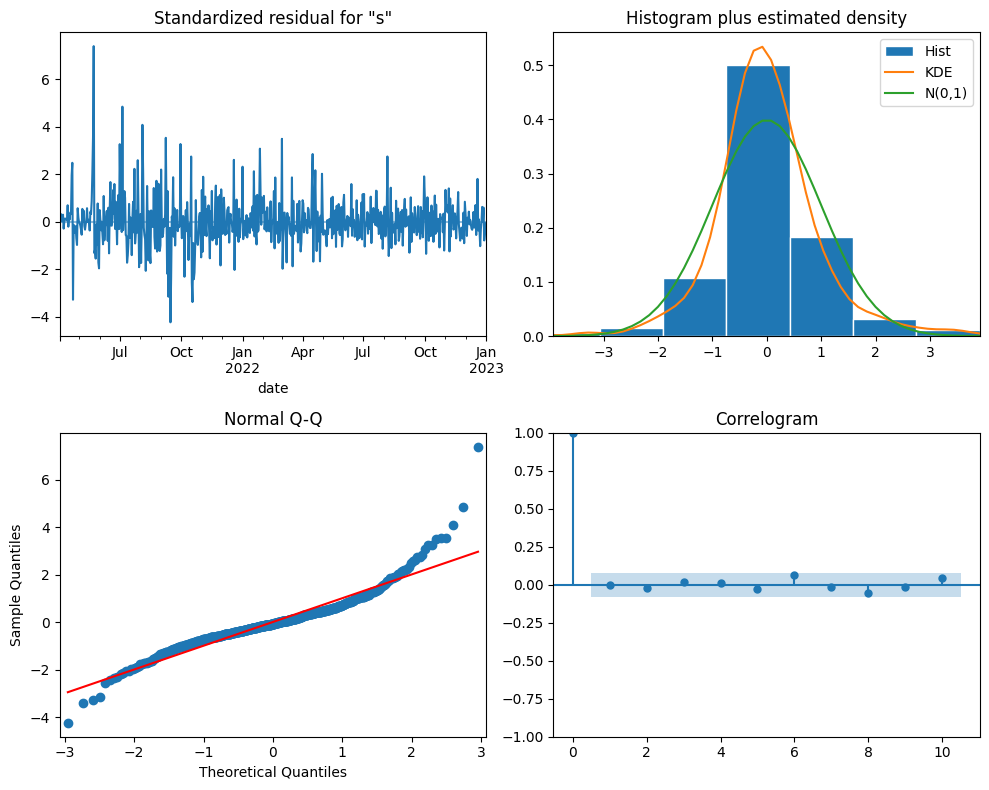

In [14]:
model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

Output results:

**Standardized residual**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Histogram**: The density plot suggest normal distribution with mean slighlty shifted towards right.

**Theoretical Quantiles**: Mostly the dots fall almost perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Correlogram**: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated.

Overall, the model seems to be a good fit. So, let's use it to forecast.

We predict the values of the time series for the training data and test data and then do the model validation for both train and test data as:

- Model validation on the **train** data helps us understand **how well the model fits the data** it was trained on. It gives us insights into the model's ability to capture the underlying patterns, relationships, and variations within the training data. It helps us **evaluate if the model has learned and represented the training data accurately**.

- Model validation on the **test** data is crucial for **assessing the model's ability to generalize to unseen data**. The test data **represents new and independent observations** that were not used during model training. By evaluating the model's performance on the test data, we can estimate **how well the model will perform in real-world scenarios** or when applied to new, unseen data.

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Predict/Forecast using train and test dataset
train_predict = model_fit.predict(start = min(train_data.index), end = max(train_data.index), exog = np.array(train_event))
test_predict = model_fit.forecast(steps = len(test_data), exog = np.array(test_event))

# Model validation for train data
print(f"RMSE for train data: {mean_squared_error(train_data['subs'], train_predict)}")
print(f"MAPE for train data: {mean_absolute_percentage_error(train_data['subs'], train_predict)}")
print(f"R2 for train data: {r2_score(train_data['subs'],train_predict)}")

# Model validation for test data
print(f"RMSE for test data: {mean_squared_error(test_data['subs'], test_predict)}")
print(f"MAPE for test data: {mean_absolute_percentage_error(test_data['subs'], test_predict)}")
print(f"R2 for test data: {r2_score(test_data['subs'], test_predict)}")

RMSE for train data: 868014.6233317266
MAPE for train data: 0.08787139116954992
R2 for train data: 0.8254322144992534
RMSE for test data: 4605499.758930938
MAPE for test data: 0.15224832014287018
R2 for test data: -2.0881862835485596


The results of the model validation for both the train and test data are as follows:

For the **train** data:

**RMSE (Root Mean Squared Error)**: 868,014.62
This metric measures the average magnitude of the residuals (prediction errors) in the same units as the target variable. A lower RMSE indicates better model performance.

**MAPE (Mean Absolute Percentage Error)**: 0.0879 (8.79%)
MAPE measures the average percentage difference between the predicted and actual values. A lower MAPE indicates better accuracy.

**R2 (Coefficient of Determination)**: 0.8254
R2 represents the proportion of the variance in the target variable that is explained by the model. It ranges from 0 to 1, and a higher value indicates a better fit to the data. In this case, the model explains around 82.54% of the variance in the train data.

For the **test** data:

**RMSE**: 4,605,499.76

**MAPE**: 0.1522 (15.22%)

**R2**: -2.0882

The negative R2 value indicates that the model performs worse than a simple horizontal line (mean) in predicting the test data. It means that the model does not capture the underlying patterns in the test data and fails to explain the variance.

Based on these results, the model seems to perform poorly on the unseen test data (as indicated by the high RMSE, MAPE, and negative R2) as it only extends to the end of the current fiscal year. This suggests that the model may not generalize well to new data, and further adjustments or alternative modeling approaches may be needed to improve its performance.

The forecasting will be undesired if we have no further approaches.

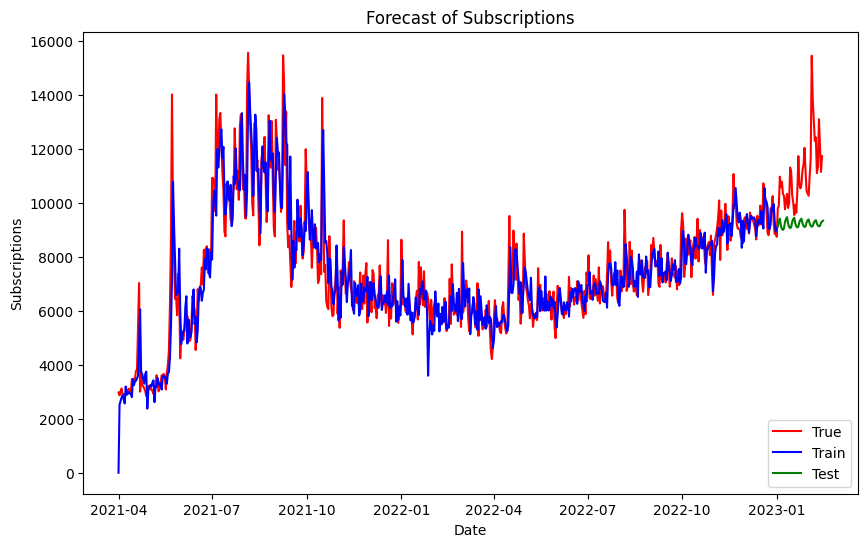

In [16]:
# Plot the actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(daily_subs.asfreq('D').index, daily_subs.asfreq('D')['subs'], color = 'red', label='True')
plt.plot(train_predict, color='blue', label='Train')
plt.plot(test_predict, color='green', label='Test')
plt.xlabel('Date')
plt.ylabel('Subscriptions')
plt.title('Forecast of Subscriptions')
plt.legend()
plt.show()

As for it, we will do the **rolling forecast** as it provide greater visibility into an extended time horizon than regular forecast. This approach allows for adapting the model to changing patterns and relationships in the data by iteratively refitting the model. It provides a sequence of predictions, where each prediction is based on the most recent available data. This can be advantageous when the data exhibits time-varying patterns or when the model's performance can benefit from incorporating new observations.

To do the rolling forecast, we will do a custom implementation that performs rolling forecasts using the SARIMAX model.

In [17]:
def rolling_forecast(train, test, order, season, exog_train, exog_test):
    history = train.values.tolist()
    exog = exog_train.values.tolist()
    predictions = []

    for i in range(len(test)):
        model = SARIMAX(history, order=order, seasonal_order=season, exog=exog)
        model_fit = model.fit(disp=False)
        yhat = model_fit.forecast(exog=[exog_test.iloc[i]])
        predictions.append(yhat)
        history.append(test.iloc[i])
        exog.append(exog_test.iloc[i])

    predictions = pd.Series(predictions, index=test.index)
    return predictions

In [18]:
train_predict = model_fit.predict(start=min(train_data.index), end=max(train_data.index), exog=np.array(train_event))
test_pred_rolling = rolling_forecast(train_data['subs'], test_data['subs'], (1, 1, 2), (1, 0, 1, 7), train_event, test_event)

# Model validation for train data
print(f"RMSE for train data: {mean_squared_error(train_data['subs'], train_predict)}")
print(f"MAPE for train data: {mean_absolute_percentage_error(train_data['subs'], train_predict)}")
print(f"R2 for train data: {r2_score(train_data['subs'], train_predict)}")

# Model validation for test data
print(f"RMSE for test data: {mean_squared_error(test_data['subs'], test_pred_rolling)}")
print(f"MAPE for test data: {mean_absolute_percentage_error(test_data['subs'], test_pred_rolling)}")
print(f"R2 for test data: {r2_score(test_data['subs'], test_pred_rolling)}")


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE for train data: 868014.6233317266
MAPE for train data: 0.08787139116954992
R2 for train data: 0.8254322144992534
RMSE for test data: 668506.1651399625
MAPE for test data: 0.04936779723459222
R2 for test data: 0.5517377748963121


The results of the model validation for both the train and test data are as follows:

For the **train** data:

**RMSE (Root Mean Squared Error)** is 868,014.62, which indicates the average difference between the actual and predicted values for the train data.

**MAPE (Mean Absolute Percentage Error)** is 0.0879, which represents the average percentage difference between the actual and predicted values.

**R2 (R-squared)** is 0.8254, which measures the proportion of the variance in the target variable that is explained by the model. An R2 value closer to 1 suggests a better fit to the data.

For the **test** data (rolling forecast):

**RMSE** is 668,506.17, which represents the average difference between the actual and predicted values for the test data using the rolling forecast approach.

**MAPE** is 0.0494, which represents the average percentage difference between the actual and predicted values for the test data.

**R2** is 0.5517, which indicates the proportion of the variance in the test data that is explained by the model.

Based on these results, it appears that the model performs reasonably well on the train data and test data.

Now, we will create a DataFrame that contains the predicted values for the test data obtained from the rolling forecast.

In [19]:
test_pred_rolling =  pd.DataFrame({'date':test_pred_rolling.index, 'subs': [x[0] for x in test_pred_rolling ]})
test_pred_rolling.set_index('date', inplace=True)
test_pred_rolling


,subs
date,
2023-01-01,9122.666951
2023-01-02,9053.883470
2023-01-03,9668.084685
2023-01-04,9510.493379
2023-01-05,10247.909954
2023-01-06,10227.005120
2023-01-07,10454.637994
2023-01-08,10336.276548
2023-01-09,10466.987551


Now, define the function performs a rolling forecast by iteratively fitting a SARIMAX model to the observed data and exogenous variables, generating one-step ahead forecasts, and appending the forecasted values to the *predictions* list. The function then returns the forecasted values as a pandas Series.

In [20]:
def rolling_forecast_no_test(train, steps, order, season, exog_train, exog_test):
    history = train.values.tolist()
    exog = exog_train.values.tolist()
    predictions = []

    for i in range(steps):
        model = SARIMAX(history, order=order, seasonal_order=season, exog=exog)
        model_fit = model.fit(disp=False)
        yhat = model_fit.forecast(exog=[exog_test.iloc[i]])
        predictions.append(yhat[0])  # Extracting the forecasted value from the array
        history.append(yhat[0])
        exog.append(exog_test.iloc[i])

    forecast_index = pd.date_range(start=train.index[-1] + pd.DateOffset(days=1), periods=steps, freq='D')
    predictions = pd.Series(predictions, index=forecast_index)
    return predictions

Now, modify the **train_event** list by adding the elements from **test_event** at the end of the list.

In [21]:
train_event.append(test_event)

<ipython-input-21-0508475d4aad>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_event.append(test_event)


,Làn sóng dịch thứ 4,Rap Viet,Nguoi Ay La Ai,2 Ngay 1 Dem,The Masked Singer
date,,,,,
2021-04-01,0,0,0,0,0
2021-04-02,0,0,0,0,0
2021-04-03,0,0,0,0,0
2021-04-04,0,0,0,0,0
2021-04-05,0,0,0,0,0
...,...,...,...,...,...
2023-02-10,0,0,0,0,0
2023-02-11,0,0,0,0,0
2023-02-12,0,0,0,0,0


Now:
- Combines the training data and the predicted values for the test data
- Combines the training events and the events corresponding to the test data

After that, generate forecasts for the future periods using the combined data stored in the Series, which contains the predicted values for the future periods based on the combined data and exogenous variables.

In [22]:
data = train_data.append(test_pred_rolling)
event = train_event.append(test_event)
forecast_rolling = rolling_forecast_no_test(data['subs'], len(forecast_event), (1, 1, 2), (1, 0, 1, 7), event, forecast_event)
forecast_rolling

<ipython-input-22-e05afec566f7>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train_data.append(test_pred_rolling)
<ipython-input-22-e05afec566f7>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  event = train_event.append(test_event)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to 

2023-02-15    11250.981580
2023-02-16    11355.156329
2023-02-17    11325.944029
2023-02-18    11794.308629
2023-02-19    12279.523316
                  ...     
2023-06-26    15755.590405
2023-06-27    15736.741584
2023-06-28    15729.781980
2023-06-29    15733.139963
2023-06-30    15729.438389
Freq: D, Length: 136, dtype: float64

Finally, plot the result of the forecast.

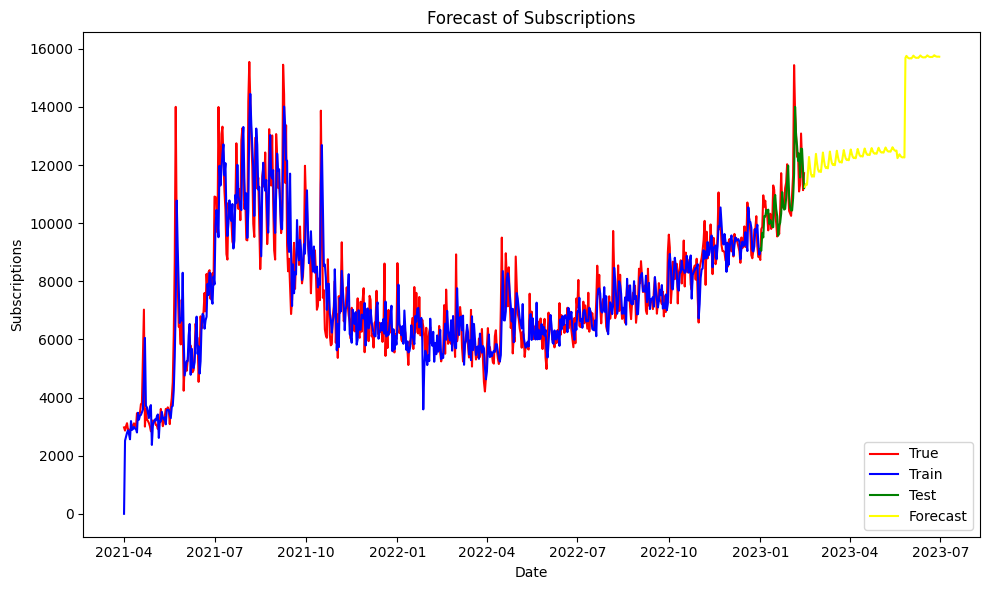

In [25]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the true values in red
plt.plot(daily_subs.asfreq('D').index, daily_subs.asfreq('D')['subs'], color='red', label='True')

# Plot the predicted values for the training data in blue
plt.plot(train_predict, color='blue', label='Train')

# Plot the predicted values for the test data using rolling forecast in green
plt.plot(test_pred_rolling, color='green', label='Test')

# Plot the forecasted values for the future periods in yellow
plt.plot(forecast_rolling, color='yellow', label='Forecast')

# Set the x-axis label, y-axis label, and title
plt.xlabel('Date')
plt.ylabel('Subscriptions')
plt.title('Forecast of Subscriptions')

# Add a legend
plt.legend()

# Adjust the layout to prevent overlapping of labels
plt.tight_layout()

# Show the plot
plt.show()

As can be observed from the forecasting result, in the future the subcription may have a moderate increase in the next three months, and experience a significant rise at the end of May 2023 and the beginning of June 2023.

This can be explained that the teaser of the program RapViet season 3 will took place and it will be released within June. As of RapViet's influence in the previous 2 seasons, RapViet season 3 has attracted a lot of attention from the audience, especially young audiences who are catching up with the trend of the times.

Therefore, the forecast is significantly reliable.